In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ephem
import math
from datetime import timedelta
import matplotlib.dates as mdates

from datetime import datetime
from dateutil.relativedelta import relativedelta


### Read in the shadow dat
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import matplotlib as mpl



In [168]:
def calculate_solar_cos_zenith(datetime_obj):
    observer = ephem.Observer()
    latitude  = 38.980762    # ERW
    longitude = -107.005017  # ERW
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = datetime_obj
    
    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude

    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith

### Get the observed data

In [169]:
master_df = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre.csv", index_col=0, parse_dates=True)                        

In [170]:
master_df['month'] = master_df.index.month
master_df['hour'] = master_df.index.hour
master_df['month'] =master_df.index.month
master_df['counter'] = 1

In [171]:
mwr=xr.open_dataset("/global/u1/r/rudisill/gshare/sail_data_will/data_store_sail_period/gucmwrlos/vap_and_liquid_mwrlos3.nc")

In [172]:
sond = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/interpsond/sond_by_pressure2/all_sondes_withq_1h.nc")
sond = sond.rename({"bar_pres":"pressure"})


In [173]:
kolias = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/kollias/cbh_kolias2.nc").to_pandas()
cloud_present_kolias = kolias.copy()
cloud_present_kolias[cloud_present_kolias == -1] = 0
cloud_present_kolias[cloud_present_kolias > 0] = 1


kolias_lt_4000 = kolias.where(kolias < 6000)
kolias_lt_4000.fillna(-1, inplace=True)
cloud_present_kolias_lt_4000 = kolias_lt_4000.copy()
cloud_present_kolias_lt_4000[cloud_present_kolias_lt_4000 == -1] = 0
cloud_present_kolias_lt_4000[cloud_present_kolias_lt_4000 > 0] = 1
master_df['cloud_present'] = cloud_present_kolias_lt_4000.resample("1h").mean().reindex(master_df.index) * 100

In [174]:
cbase = kolias.where(kolias > 0)
cbase_1h = cbase.resample("1h").mean()
master_df['cbase_1h'] = cbase_1h.reindex(master_df.index)

In [175]:
master_df['cre_lw'] = master_df['qcrad_lwd'] - master_df['rrtmg_lwd_clear']
inv_temp = (sond.temp.sel(level=0) - sond.temp.sel(level=18)).to_pandas().reindex(master_df.index)

### start making figures 

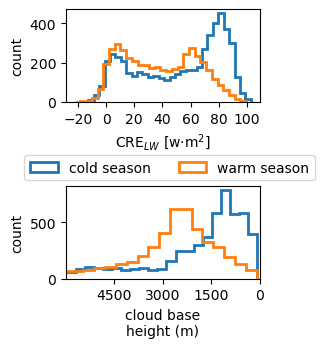

In [176]:
fig,ax=plt.subplots(2,1, figsize=(2.5,3.5))

cold_22 = slice("2021-09-01", "2022-04-01")
warm_22 = slice("2022-04-01", "2022-10-01")
cold_23 = slice("2022-10-01", "2023-04-01")
warm_23 = slice("2023-04-01", "2023-06-15")


warm_season = master_df[master_df.index.month.isin([4,5,6,7,8,9])]
cool_season = master_df[master_df.index.month.isin([10,11,12,1,2,3])]


cool_season.cbase_1h.where(cool_season.cloud_present>10).plot.hist(bins=30, density=False, histtype='step', linewidth=2, ax=ax[1], label="cold season")
warm_season.cbase_1h.where(warm_season.cloud_present>10).plot.hist(bins=30, density=False, histtype='step', linewidth=2, ax=ax[1], label="warm season")


# #df['2022-04-01':'2022-04-01'].where(df.k30mc>0).k30mc.plot.hist(bins=80)
ax[1].set_xlim(6000, 0)
leg=ax[1].legend(loc='upper left', ncol=2, bbox_to_anchor=(-.25, 1.4))
# leg.set_title("Season")

cool_season.where(cool_season.cbase_1h>0).where(cool_season.cloud_present>10).cre_lw.plot.hist(bins=30, density=False, histtype='step', linewidth=2, ax=ax[0], label="cold season")
warm_season.where(warm_season.cbase_1h>0).where(warm_season.cloud_present>10).cre_lw.plot.hist(bins=30, density=False, histtype='step', linewidth=2, ax=ax[0], label="warm season")


ax[0].set_xlabel("CRE$_{LW}$ [w$\cdot$m$^2$]")
ax[1].set_xlabel("cloud base\nheight (m)")

ax[0].set_ylabel("count")
ax[1].set_ylabel("count")
ax[1].set_xticks(np.arange(0, 6000, 1500))
ax[0].set_xticks(np.arange(-20,120, 20))


fig.subplots_adjust(hspace=.9)


In [177]:
cbase_with_nodat = master_df.cbase_1h.where(master_df.cbase_1h<6000)
cbase_with_nodat = cbase_with_nodat.fillna(9999)

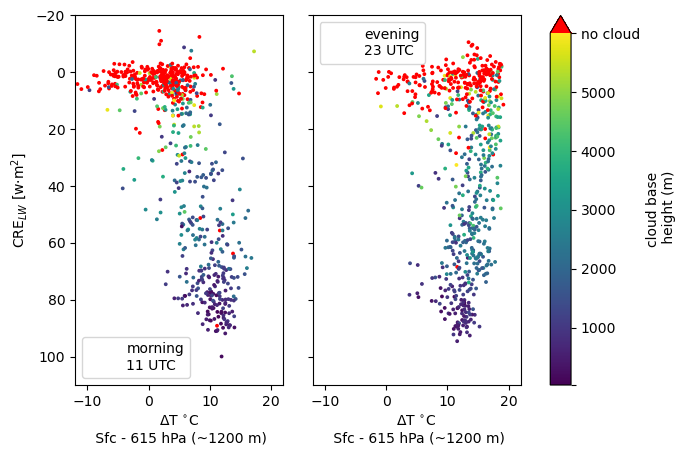

In [178]:

cmap_custom = mpl.cm.viridis

fig, ax = plt.subplots(1,3, gridspec_kw={"width_ratios":[1,1,.1]})
ax[0].scatter(inv_temp.where(master_df.cre_lw.index.hour.isin([11])), 
            master_df.cre_lw.where(master_df.cre_lw.index.hour.isin([11])), 
            c=cbase_with_nodat.where(master_df.index.hour.isin([11])),
            #c= np.cos(cre_lw.where(cre_lw.index.hour.isin([11])).index.dayofyear/365 * 2*np.pi),
            vmin=30,
            vmax=6000,
            cmap=cmap_custom,
            s=3, label='morning\n11 UTC')

cmap_custom = mpl.cm.viridis
cmap_custom.set_over('r')


cb = ax[1].scatter(inv_temp.where(master_df.cre_lw.index.hour.isin([23])), 
            master_df.cre_lw.where(master_df.cre_lw.index.hour.isin([23])), 
            #c= np.cos(cre_lw.where(cre_lw.index.hour.isin([11])).index.dayofyear/365 * 2*np.pi),
            c=cbase_with_nodat.where(master_df.index.hour.isin([23])),
            vmin=30,
            vmax=6000,
            cmap=cmap_custom,
            s=3, label='evening\n23 UTC')



ax[0].legend()
ax[1].legend()


cbar=fig.colorbar(cb, cax=ax[2], cmap=cmap_custom, extend='max')
cbar.set_label('cloud base\n height (m)')
cbar.set_ticks([30, 1000, 2000, 3000, 4000, 5000, 6000])
cbar.set_ticklabels([' ', '1000', '2000', '3000', '4000', '5000', 'no cloud'])

for axx in ax.flatten()[:-1]:
    axx.set_xlim(-12,22)
    axx.set_xlabel("$\Delta$T $^{\circ}$C \n Sfc - 615 hPa (~1200 m)")

ax[1].set_yticklabels([])
ax[0].set_ylabel("CRE$_{LW}$ [w$\cdot$m$^2$]")

for axx in [ax[0], ax[1]]:
    axx.set_ylim(110, -20)

In [179]:
pwv= mwr.vap.where(mwr.qc_vap ==0).resample(time="1h").mean().to_pandas()

In [180]:
def avg_gridder(x,y,z, bins, cutoff):
    # the "cutoff" defines the bins to throw out if the fraction (# per bin/total) is less than cutoff
    # e.g. .01 == 1% of the total datapoints are in that region
    counts, xbins, ybins   = np.histogram2d(x, y, bins=bins)
    sums, _, _             = np.histogram2d(x, y, weights=z, bins=(xbins, ybins))
    avg = sums/counts
    avg = np.where(counts/len(x) > cutoff, avg, np.nan)
    return ybins, xbins, avg


In [181]:
def count_gridder(x,y,z, bins):
    counts, xbins, ybins   = np.histogram2d(x, y, bins=bins)
    return xbins, ybins, counts


In [182]:
cmap_custom = mpl.cm.Spectral
cmap_custom.set_over('b')




df_for_2dhist = pd.DataFrame({"pwv":pwv[master_df.cre_lw.index], "cbase":cbase_with_nodat[master_df.cre_lw.index], "cre_lw":master_df.cre_lw}).dropna()
df_for_2dhist_with_cloud = df_for_2dhist.where(cbase_with_nodat < 9999).dropna()
df_for_2dhist_no_cloud = df_for_2dhist.where(cbase_with_nodat == 9999).dropna()


ybins, xbins, avg          = avg_gridder(df_for_2dhist_with_cloud.cre_lw,  df_for_2dhist_with_cloud.pwv, df_for_2dhist_with_cloud.cbase, bins=(25,25), cutoff=1/10000.)
# number or no cloud points 
ybins2, xbins2, counts2  = count_gridder(df_for_2dhist_no_cloud.cre_lw,  df_for_2dhist_no_cloud.pwv, df_for_2dhist_no_cloud.cbase, bins=(25,25))

# number of cloud points 
ybins3, xbins3, counts3  = count_gridder(df_for_2dhist_with_cloud.cre_lw,  df_for_2dhist_with_cloud.pwv, df_for_2dhist_with_cloud.cbase, bins=(25,25))
total_counts  = counts2 + counts3 
with_cloud_frac = counts3/total_counts   # cloud points over total 

# we want to compute the average of the cloud regions if it is g.t. 80 percent 
#no_cld_count = np.where((with_cloud_frac < .8), 9999, np.nan)
avg = np.where((with_cloud_frac > .001), avg, np.nan)
#avg = np.where( counts3 > 1, avg, no_cld_count)




/tmp/ipykernel_1898433/1810959201.py:6: RuntimeWarning: invalid value encountered in divide
  avg = sums/counts
/tmp/ipykernel_1898433/1976224307.py:19: RuntimeWarning: invalid value encountered in divide
  with_cloud_frac = counts3/total_counts   # cloud points over total


In [183]:
### do an SVM thing
df_for_2dhist_with_cloud['season'] = 1
df_for_2dhist_with_cloud['season'][df_for_2dhist_with_cloud.index.month.isin([4,5,6,7,8,9])] = 0
x = df_for_2dhist_with_cloud.pwv
y = df_for_2dhist_with_cloud.cre_lw
z = df_for_2dhist_with_cloud.cbase
labels = df_for_2dhist_with_cloud.season



model = SVC(kernel='rbf', probability=True)

# Fit the model
model.fit(np.vstack((x, y,)).T, labels)

# Plot the scatter plot# Create a grid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict probabilities for the grid
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

# Plot the decision boundary
# contour = plt.contour(xx, yy, probs, levels=[0.5], linewidths=2, colors='red')
# plt.clabel(contour, inline=True, fontsize=10)
# # Add labels and legend
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.title('SVM with RBF Kernel Decision Boundary')
# plt.show()


/tmp/ipykernel_1898433/3864595958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_2dhist_with_cloud['season'][df_for_2dhist_with_cloud.index.month.isin([4,5,6,7,8,9])] = 0


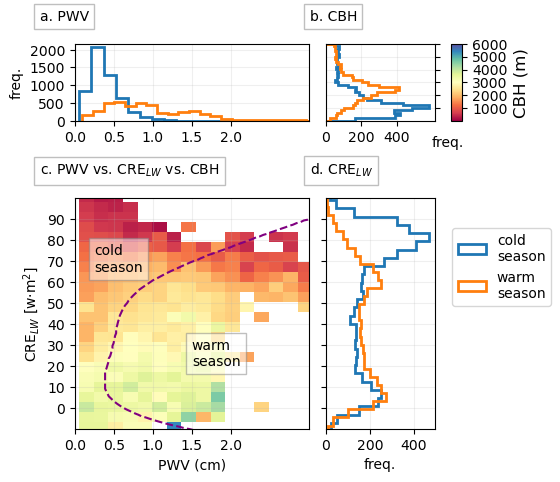

In [188]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Create some sample data
data = np.random.randn(1000)

# Create the figure
fig = plt.figure(figsize=(5,5))

# Create the GridSpec layout
gs = gridspec.GridSpec(3,4, width_ratios=[1,1,1,.1])

# Bottom-left plot: 2/3 width, 2/3 height
ax_bottom_left = fig.add_subplot(gs[1:, :2])

# Top histogram: 2/3 width, 1/3 height
ax_top = fig.add_subplot(gs[0, :2])

# Right histogram: 1/3 width, 2/3 height
ax_right = fig.add_subplot(gs[1:, 2])

# the top one 
ax_top_right = fig.add_subplot(gs[0, 2])


# cbar one 
ax_cbar = fig.add_subplot(gs[0,3])


#### make the center plot 
im=ax_bottom_left.pcolormesh(ybins, xbins, avg, cmap=cmap_custom, vmax=6000)
im.set_clim(30, 6000)

ax_bottom_left.set_ylabel(r"CRE$_{LW}$ [w$\cdot$m$^2$]")

cbar = fig.colorbar(im, cax=ax_cbar)
cbar.set_label("CBH (m)", fontsize=12, loc='center')


#ax_bottom_left.scatter(df_for_2dhist_with_cloud.pwv, df_for_2dhist_with_cloud.cre_lw, color='gray', alpha=.5, s=.05)


contour = ax_bottom_left.contour(xx, yy, probs, levels=[0.5], linewidths=1.5,  linestyles='--', colors='purple')
#ax_bottom_left.clabel(contour, inline=True, fontsize=9)
ax_bottom_left.set_ylim(0,100)


### make the right plot 
cscrelw = df_for_2dhist_with_cloud[df_for_2dhist_with_cloud.index.month.isin([10,11,12,1,2,3])].cre_lw
wscrelw = df_for_2dhist_with_cloud[df_for_2dhist_with_cloud.index.month.isin([4,5,6,7,8,9])].cre_lw
cscrelw.plot.hist(bins=30, density=False, histtype='step', orientation='horizontal', linewidth=2, ax=ax_right, label="cold\nseason")
wscrelw.plot.hist(bins=30, density=False, histtype='step', orientation='horizontal', linewidth=2, ax=ax_right, label="warm\nseason")


### make the top plot 
cspwv = df_for_2dhist_with_cloud[df_for_2dhist_with_cloud.index.month.isin([10,11,12,1,2,3])].pwv
wspwv = df_for_2dhist_with_cloud[df_for_2dhist_with_cloud.index.month.isin([4,5,6,7,8,9])].pwv
cspwv.plot.hist(bins=30, density=False, histtype='step',  linewidth=2, ax=ax_top, label="cold\nseason")
wspwv.plot.hist(bins=30, density=False, histtype='step',  linewidth=2, ax=ax_top, label="warm\nseason")


# make the top right plot 
cscbh = df_for_2dhist_with_cloud[df_for_2dhist_with_cloud.index.month.isin([10,11,12,1,2,3])].cbase
wscbh = df_for_2dhist_with_cloud[df_for_2dhist_with_cloud.index.month.isin([4,5,6,7,8,9])].cbase
cscbh.plot.hist(bins=30, density=False, histtype='step', orientation='horizontal', linewidth=2, ax=ax_top_right, label="cold\nseason")
wscbh.plot.hist(bins=30, density=False, histtype='step', orientation='horizontal', linewidth=2, ax=ax_top_right, label="warm\nseason")


### do a buch of stuff 
legend = ax_right.legend(ncol=1, bbox_to_anchor=(1.1,.9))
#for text in legend.get_texts():
#    text.set_rotation(270)


# limits 
ax_bottom_left.set_xlim(0,3)
ax_top.set_xlim(0,3)
ax_top.set_yticks(np.arange(0,2500,500))

ax_top_right.set_ylim(30, 6000)
ax_top_right.set_yticks(np.arange(1000,7000,1000))
cbar.set_ticks(np.arange(1000,7000,1000))

ax_top_right.set_yticklabels([])
ax_top_right.set_xticks(np.arange(0,600,200))
ax_top_right.text(600, -2000, "freq.")

ax_bottom_left.set_ylim(-10,100)
ax_right.set_ylim(-10,100)
ax_right.set_xticks(np.arange(0,600,200))

# tick stuff
ax_right.set_yticklabels([])
ax_top.set_xticks([])
ax_top_right.yaxis.tick_right()
#ax_top_right.xaxis.tick_top()

for axx in [ax_top, ax_bottom_left]:
    axx.set_xticks([0, .5, 1., 1.5, 2])

ax_top.grid(alpha=.2)
ax_top_right.grid(alpha=.2)


for axx in [ax_bottom_left, ax_right]:
    axx.set_ylim(-10,100)
    axx.set_yticks(np.arange(0,100,10))
    axx.grid(alpha=.2, zorder=0)




# text stuff
#ax_top_right.text(250, 4000, 'cbh')
tx1=ax_bottom_left.text(.25, 65, "cold\nseason")
tx2=ax_bottom_left.text(1.5, 20, "warm\nseason")
tx1.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='gray'))
tx2.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='gray'))


# label stuff
ax_top_right.set_xlabel("")
ax_bottom_left.set_xlabel("PWV (cm)")



## make a bunch of a,b,c,d labels 
hgt=1.3
tx1=ax_top.text(-.15, hgt, "a. PWV",         transform=ax_top.transAxes)
tx2=ax_top_right.text(-.15, hgt, "b. CBH",  transform=ax_top_right.transAxes)

hgt=1.1
tx3=ax_bottom_left.text(-.15, hgt, "c. PWV vs. CRE$_{LW}$ vs. CBH", transform=ax_bottom_left.transAxes)
tx4=ax_right.text(-.15, hgt, r"d. CRE$_{LW}$", transform=ax_right.transAxes)

for tx in [tx1, tx2, tx3, tx4]:
    tx.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='gray'))


# rename a bunch of things 
ax_top.set_ylabel("freq.")
ax_right.set_xlabel("freq.")

# adjust 
plt.subplots_adjust(hspace=1, wspace=.2)
plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_vapor_crelw_cbh.png", dpi=300,  bbox_inches="tight")



### Make a hist of just the MWR data

In [185]:
mwr_liq = mwr.liq.where(mwr.qc_liq ==0).to_pandas()

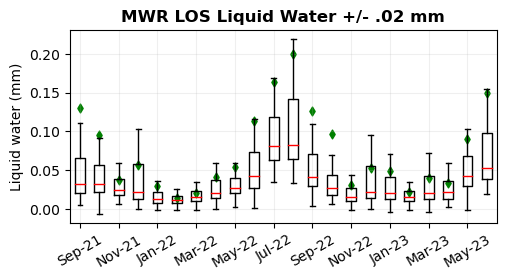

In [186]:
fig,ax=plt.subplots(figsize=(5.5,2.5))
k=0
for gp in mwr_liq.resample("1h").mean().resample("m"):
    ax.boxplot(10 * gp[1].dropna(), positions=[k], showfliers=False, widths=.5, showmeans=False, whis=1, medianprops=dict(color='red'))
    ax.scatter(k, np.mean(10 * gp[1].dropna()), color='green', marker='d', s=20)

    k+=1

ax.set_ylabel("Liquid water (mm)")
ax.set_title("MWR LOS Liquid Water +/- .02 mm", fontweight='bold')

the_dates = [datetime(2021, 9, 1)  + relativedelta(months=i) for i in range(22)]
the_dates = [x.strftime("%b-%y") for x in the_dates]

ax.set_xticks(np.arange(0,22,2))
ax.set_xticklabels(the_dates[::2], rotation=30)
ax.grid(alpha=.2)